In [31]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import os
import glob, cv2, time, math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3, VGG19
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore") 

## Deep Neural Network with Dropout & L2 Regularization & ADAM Optimizer

In [2]:
def parameters_initialization(layers):
    
    """
    To Initialize Parameters in Deep Neural Network
    
    Arguments : 
    
        layers: How many layers in the DNN model
        
    Returns   :
    
        Parameters
    """
    np.random.seed(3)
    parameter = {}
    len_layers = len(layers)
    for l in range(1,len_layers):
        parameter["W"+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/layers[l-1])
        parameter["b"+str(l)] = np.zeros((layers[l],1))
    return parameter

def initialize_adam(parameters) :
    
    """
    To Initialize Parameters v and s for ADAM Optimizer
    
    Arguments : 
    
        parameters : all parameters in model
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    
        v["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    To update all parameters in model
    
    Arguments : 
    
        parameters : all parameters in model
        grads : gradient of parameters
        v : ADAM parameters
        s : ADAM parameters
        t : Current layer
        learning_rate : learning rate
        beta1 : ADAM beta parameter 
        beta2 : ADAM beta parameter
        epsilon : epsilon
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)
        
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*(grads["dW" + str(l)])**2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*(grads["db" + str(l)])**2

        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*(v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)])+epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*(v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)])+epsilon))

    return parameters, v, s, v_corrected, s_corrected

def sigmoid(Z):
    
    """
    Activation Function where the value lies between (0,1) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Sigmoid function
        Z     : Linear value
        
    """
    val = 1./(1. + np.exp(-Z))
    return val, (val,Z)

def relu(Z):
    
    """
    Activation Function where the value lies between [0,inf) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Relu function
        Z     : Linear value
        
    """
    val = np.maximum(0.0,Z)
    return val, (val,Z)

def sigmoid_backward(AL, Y, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        Al    : Linear value
        Y     : Actual prediction
        cahce : contains (Z)
        
    Returns   :
        
        dZ   : the output of derivative
    """
    Z = cache[1]
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A = cache[0]
    Z = cache[1]
    dZ = np.multiply(dA, np.int64(A > 0))
    assert (dZ.shape == Z.shape)
    return  dZ

def back_prop_linear(dZ, caches):
    """
    To compute 
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = 1./m * (np.dot(dZ, A_prev.T))
    db = 1./m * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def forward_prop_linear(A_prev, W, b):
    
    """"
    To compute linear function (Z)
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        
    Returns   :
        
        Z  : the output of lineas function
        caches : (A_prev, W, b)
    """
    Z = np.dot(W,A_prev) + b
    caches = (A_prev, W, b)
    return Z, caches

def forward_prop_activation(A_prev, W, b, activation):
    
    """"
    To compute Activation function 
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        activation : 'relu' or 'sigmoid'
        
    Returns   :
        
        A : the output of activation function
        caches : (linear caches, activation caches)
    """
    
    if activation == "sigmoid":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = relu(Z)
    caches = (linear_caches,activation_caches)
    return A , caches

def L_forward_prop(X, parameters):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def L_forward_prop_dropout(X, parameters, keep_prob):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        keep_prob : [0,1] values
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        D = np.random.rand(A.shape[0],A.shape[1])
        D = (D <= keep_prob).astype('int64')
        A = np.multiply(A,D)/keep_prob
        cache = cache + (D,)
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def back_prop_linear_with_regularization(dZ, caches, lambd):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = (1./m) * (np.dot(dZ, A_prev.T)) + (lambd/m)*W 
    db = (1./m) * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation_with_regularization_dropout(dA, Y, cache, lambd, activation):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    if activation == "sigmoid":
        linear_cache, activation_cache = cache
        dZ  = sigmoid_backward(dA, Y, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    elif activation == "relu":
        linear_cache, activation_cache, D = cache
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    return dA_prev, dW, db

def L_back_prob_with_regularization_dropout(Y, AL, lambd, caches, keep_prob):
    
    """"
    To compute all parameters gradient
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        lambd : Regularization value
        caches : (linear caches, activation caches)
        keep_prob : [0,1] values
        
    Returns   :
        
        grads : gradient of all parameters
    """
    
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)

    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(AL, Y, current_cache, lambd, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        grads["dA"+ str(i+1)] = np.multiply(grads["dA"+ str(i+1)], current_cache[-1])/keep_prob
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(grads["dA"+ str(i+1)],Y, current_cache, lambd, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def compute_cost_with_regularization(AL, Y, parameters,  lambd):
    
    """"
    To compute cost
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        parameters : parameters
        lambd : Regularization value
        
    Returns   :
        
        cost :cost
    """
    
    
    m = Y.shape[1]
    n_params = len(parameters) // 2
    cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
    L2_sum = 0
    
    for l in range(1, n_params + 1):
        L2_sum += np.sum(np.square(parameters["W" + str(l)]))
        
    L2_cost = (lambd/(2.*m))*L2_sum
    
    cost = cost_original + L2_cost
    return cost


def L_layer_model_with_regularization_adam(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_iterations = 3000, keep_prob = 1,  print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X : data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y : true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims : list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate : learning rate of the gradient descent update rule
    num_iterations : number of iterations of the optimization loop
    keep_prob : [0,1] value
    print_cost : if True, it prints the cost every 100 steps
    
    Returns:
    parameters : parameters learnt by the model. They can then be used to predict.
    grads : gradient of model
    cost : cost of model
    train_acc : training accuracy
    test_acc : testing accuracy

    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)
    v, s = initialize_adam(parameters)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop_dropout(X_train, parameters, keep_prob)
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y_train, parameters,  lambd)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob_with_regularization_dropout(Y_train, AL, lambd, caches, keep_prob)
 
        # Update parameters.
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, i+1, learning_rate , beta1, beta2, epsilon)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc

def plot_costs(costs, learning_rate=0.0075):
    
    """"
    To draw plot of cost
    
    Arguments :
        
        cost : cost
        learing_rate : learning rate
        
    Returns   :
        
        cost plot
    """
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def accuracy_score(y_true, y_pred):
    """"
    To calculate an accuracy score
    
    Arguments :
        
        y_true : Actual value
        y_test : Prediction value
        
    Returns   :
        
        accuracy : accuracy
    """
    y_true = np.squeeze(y_true)
    y_pred = np.round(np.squeeze(y_pred)).astype("int64")
    m = len(y_pred)
    correct = len(y_pred[y_pred == y_true])
    accuracy = correct/m
    return accuracy

In [3]:
# Create data from sklearn library.

X, y = make_classification(n_samples = 10000, n_features = 15, n_informative = 10, n_redundant = 2, n_classes = 2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.05,  random_state = 42)

In [4]:
# Create classification model

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
important_features = rf.feature_importances_
report = classification_report(y_test, y_pred)

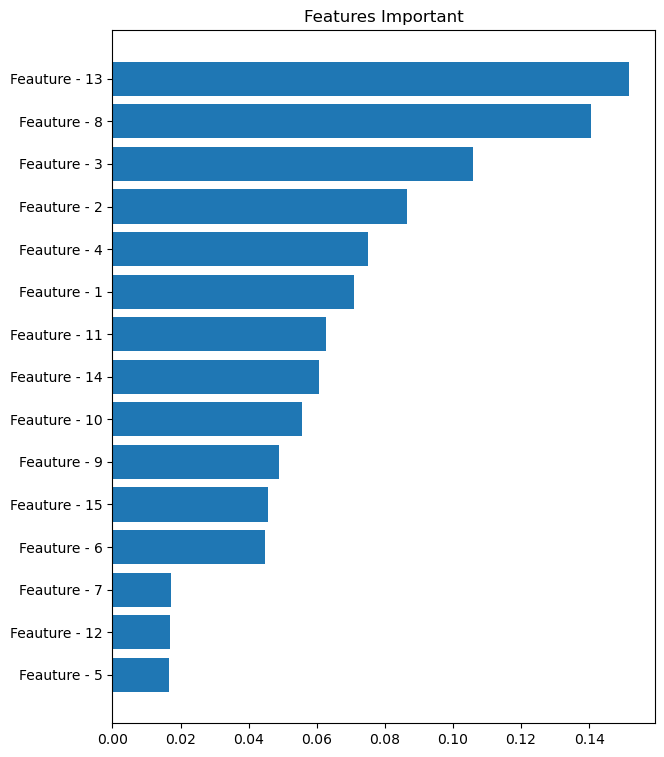

In [5]:
# Feature importance visualizaition.

sorted_idx = np.argsort(important_features)
sorted_important_features = important_features[sorted_idx]
sorted_label_features = np.array([f"Feauture - {i}" for i in range(1,16)])[sorted_idx]

fig, ax = plt.subplots(figsize = (7,9))
ax.barh( y = np.arange(1,16) , width = sorted_important_features)
ax.set_yticks(np.arange(1,16))
ax.set_yticklabels(sorted_label_features)
ax.set_title("Features Important")
plt.show()

In [6]:
## Classification report.

print("Classification report for Random Forest :")
print(report)

Classification report for Random Forest :
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       250
           1       0.92      0.93      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



In [7]:
## Preprocessing data before applied to Deep Neural Network Model/

X_train_tf = X_train.T
X_test_tf = X_test.T
y_train_tf = y_train.reshape(1,-1)
y_test_tf = y_test.reshape(1,-1)

print("Training Data Shape :")
print(f"X = {X_train_tf.shape}")
print(f"Y = {y_train_tf.shape}")
print("Testing Data Shape :")
print(f"X = {X_test_tf.shape}")
print(f"Y = {y_test_tf.shape}")

Training Data Shape :
X = (15, 9500)
Y = (1, 9500)
Testing Data Shape :
X = (15, 500)
Y = (1, 500)


In [11]:
## Create Deep Neural Network Model

layers = [15, 250, 100, 50, 25, 5, 1] # 10 layers
parameters, grads, costs, train_acc, test_acc =  L_layer_model_with_regularization_adam(X_train_tf, y_train_tf, X_test_tf, y_test_tf, layers, learning_rate = 0.00005, 
                                                                                        lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-7, num_iterations = 2000, keep_prob = 1,  print_cost = True)

Cost after iteration 0: 0.8495884288666729
Cost after iteration 100: 0.343500393621168
Cost after iteration 200: 0.21156740152122663
Cost after iteration 300: 0.15962398293428842
Cost after iteration 400: 0.13039592370131498
Cost after iteration 500: 0.1117613334655892
Cost after iteration 600: 0.09833158413325882
Cost after iteration 700: 0.08803033738268493
Cost after iteration 800: 0.07966446034177745
Cost after iteration 900: 0.07255311401581577
Cost after iteration 1000: 0.06629273413100847
Cost after iteration 1100: 0.06047010256213708
Cost after iteration 1200: 0.05496910743386895
Cost after iteration 1300: 0.049745174348199535
Cost after iteration 1400: 0.044798575614999406
Cost after iteration 1500: 0.04013064665643651
Cost after iteration 1600: 0.03574903313620939
Cost after iteration 1700: 0.031699410871755616
Cost after iteration 1800: 0.02794540021966269
Cost after iteration 1900: 0.02450016812429908
Cost after iteration 1999: 0.021442361466410806


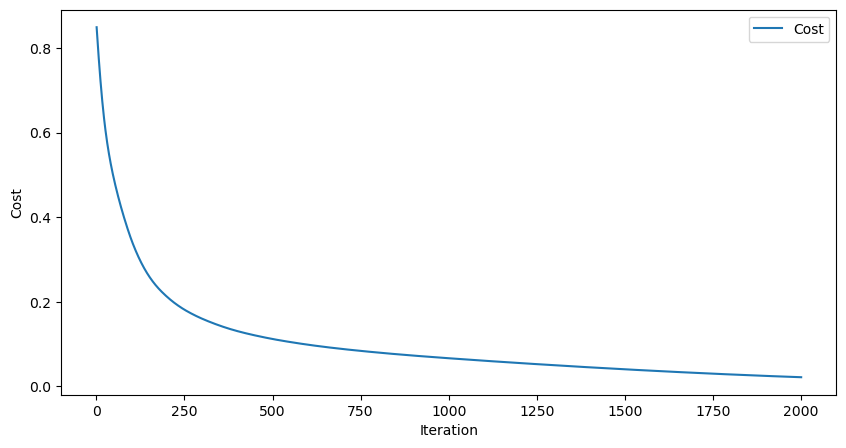

In [12]:
## Cost function visualization.

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(costs)+1), costs, label = 'Cost')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.legend()
plt.show()

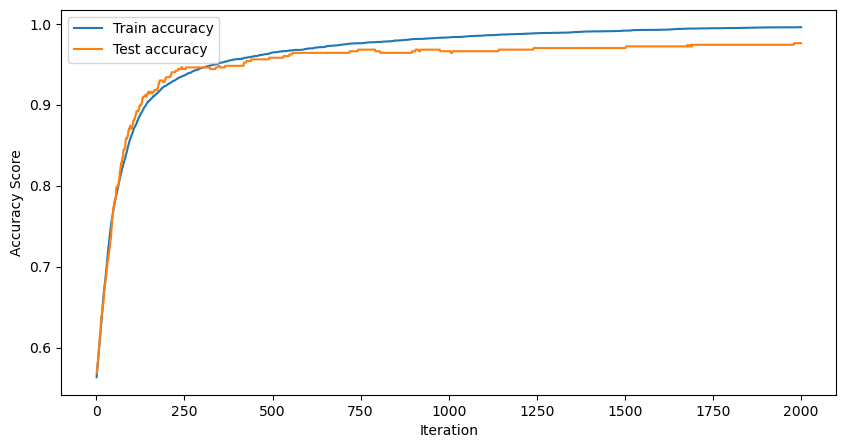

In [13]:
## Accuracy visualization.

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(train_acc)+1), train_acc, label = 'Train accuracy')
ax.plot(np.arange(1,len(test_acc)+1), test_acc, label = 'Test accuracy')
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy Score")
ax.legend()
plt.show()

In [14]:
## Classification report.

y_pred , _ = L_forward_prop(X_test_tf, parameters)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       250
           1       0.96      1.00      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



## Image Recognition With CNN

In [40]:
# Load Imanges From Directory.

training_dir = "C:/Users/naufa/Car-Bike-Dataset/Training"
validation_dir = "C:/Users/naufa/Car-Bike-Dataset/Validation"
testing_dir = "C:/Users/naufa/Car-Bike-Dataset/Testing"

training_gen = ImageDataGenerator(rescale = 1/255)
training_img = training_gen.flow_from_directory(directory  = training_dir, target_size = (250,250), batch_size = 50,
                                               class_mode = 'binary', shuffle = False)

validation_gen = ImageDataGenerator(rescale = 1/255)
validation_img = validation_gen.flow_from_directory(directory = validation_dir, target_size = (250,250), batch_size = 25,
                                                   class_mode = 'binary', shuffle = False)

Found 4000 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [16]:
img_train, labels_train = training_img.next()
print(img_train.shape)
print(labels_train.shape)

(50, 250, 250, 3)
(50,)


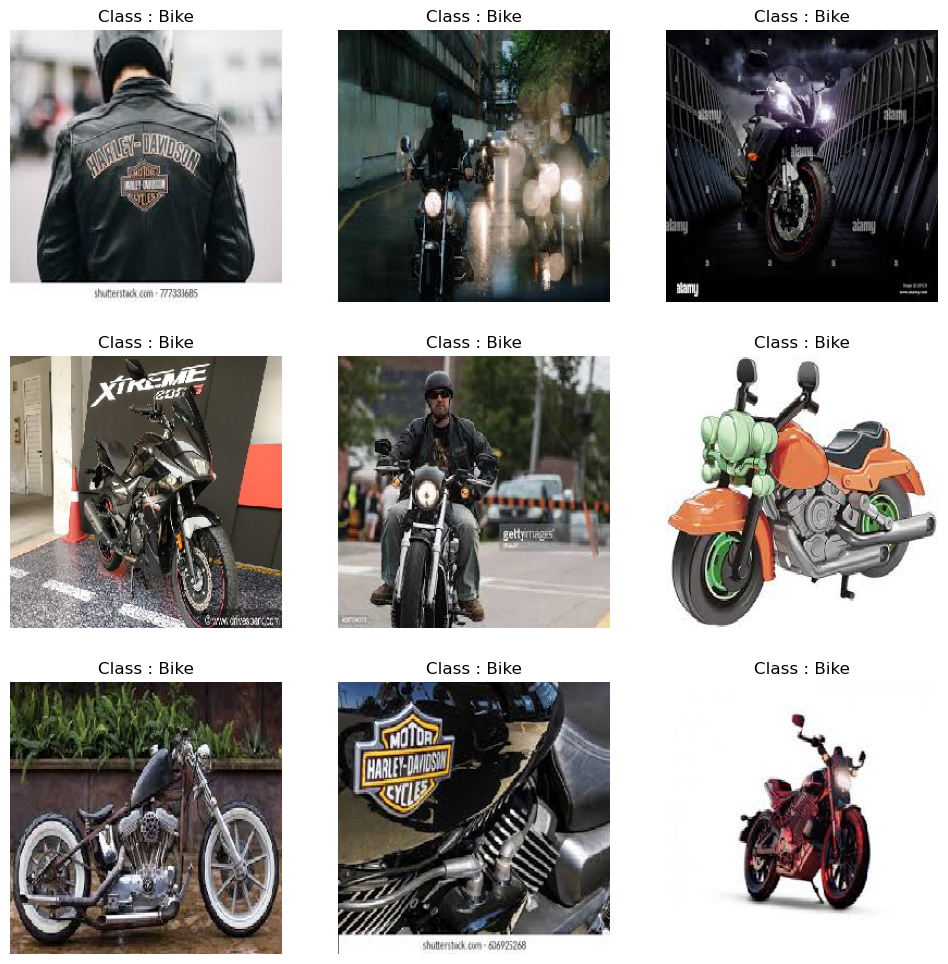

In [17]:
## Take 9 image samples from training images.

categories = ["Bike","Car"]
img_train, labels_train = training_img.next()

n_rows = 3
n_cols = 3

fig = plt.gcf()
fig.set_size_inches(n_cols*4, n_rows*4)

for i, img in enumerate(img_train[:9]):
    
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') 
    plt.title(f"Class : {categories[labels_train[i].astype('uint8')]}")
    plt.imshow(img)



##  CNN With Tensorflow For Image Classification

In [18]:
## Create Class For CallBacks.

class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
            print("\nReached 98.0 % accuracy so cancelling training!")
            self.model.stop_training = True

In [19]:
## Define Hyperparameters.

learning_rate = 0.001
epoch = 15
callbacks = MyCallBack()

## LeNet50 CNN Architecture 

In [48]:
## Create  Model's Layers.

model_1 = keras.Sequential([
    keras.layers.Conv2D(6, (5,5), activation = 'tanh', strides = 1, input_shape = (250,250,3)),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Conv2D(16, (5,5), activation = 'tanh', strides = 1),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'tanh'),
    keras.layers.Dense(84, activation = 'tanh'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [49]:
## Compile and Print the summary of the model.

model_1.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), 
                loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 246, 246, 6)       456       
                                                                 
 average_pooling2d_4 (Averag  (None, 123, 123, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_20 (Conv2D)          (None, 119, 119, 16)      2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 59, 59, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_5 (Flatten)         (None, 55696)             0         
                                                                 
 dense_15 (Dense)            (None, 120)              

In [50]:
## Model Fitting.

history = model_1.fit(x = training_img, epochs = epoch, callbacks = [callbacks], validation_data = validation_img)

Epoch 1/15
80/80 [==============================] - 37s 455ms/step - loss: 1.0579 - accuracy: 0.4645 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 2/15
80/80 [==============================] - 39s 487ms/step - loss: 0.7172 - accuracy: 0.4750 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/15
80/80 [==============================] - 40s 501ms/step - loss: 0.7307 - accuracy: 0.3875 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 4/15
80/80 [==============================] - 41s 514ms/step - loss: 0.7053 - accuracy: 0.5500 - val_loss: 0.7155 - val_accuracy: 0.5000
Epoch 5/15
80/80 [==============================] - 42s 518ms/step - loss: 0.6979 - accuracy: 0.5625 - val_loss: 0.7533 - val_accuracy: 0.5000
Epoch 6/15
80/80 [==============================] - 39s 487ms/step - loss: 0.7183 - accuracy: 0.5125 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 7/15
80/80 [==============================] - 38s 476ms/step - loss: 0.7169 - accuracy: 0.4625 - val_loss: 0.6933 - val_accuracy: 0.5000

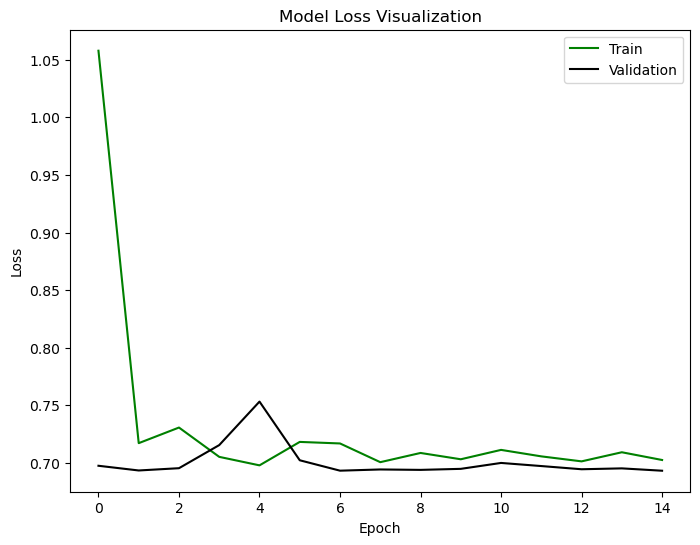

In [51]:
## loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

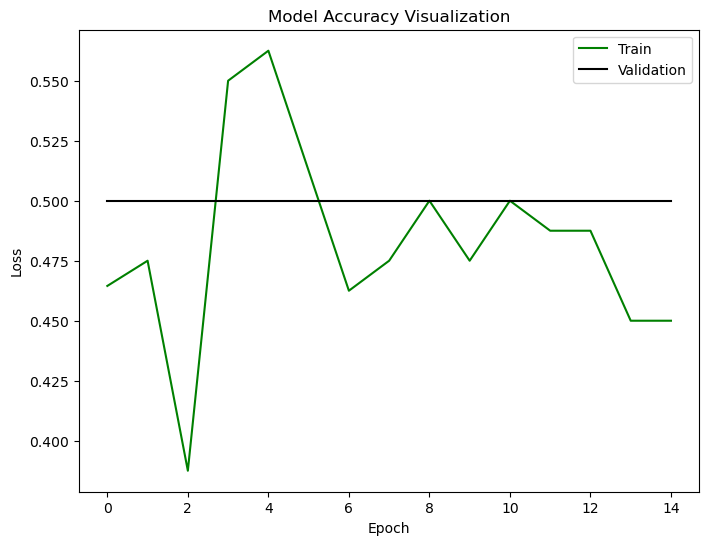

In [52]:
## Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [53]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

12/12 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       140
           1       0.00      0.00      0.00       140

    accuracy                           0.50       280
   macro avg       0.25      0.50      0.33       280
weighted avg       0.25      0.50      0.33       280



In [54]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 82ms/step
Classification report :

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



In [55]:
val_acc_score_model_1 = np.round(history.history['accuracy'],2)
test_acc_score_model_1 = accuracy_score(labels, test_pred)

## AlexNet CNN Architecture

In [37]:
## Create model's layers.

model_2 = keras.Sequential([
    keras.layers.Conv2D(96, (11,11), strides = 4, activation = 'relu', input_shape = (250,250,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(256, (5,5), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(256, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [38]:
## Compile and print the summary of the model.

model_2.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 60, 60, 96)        34944     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 20, 96)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 256)       614656    
                                                                 
 batch_normalization_5 (Batc  (None, 20, 20, 256)      1024      
 hNormalization)                                                 
                                                      

In [39]:
## Model fitting.

history = model_2.fit(x = training_img, epochs = epoch, validation_data = validation_img, callbacks = [callbacks])

Epoch 1/15
80/80 [==============================] - 53s 661ms/step - loss: 34.6551 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
80/80 [==============================] - 52s 643ms/step - loss: 0.7069 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/15
80/80 [==============================] - 51s 642ms/step - loss: 0.6914 - accuracy: 0.4678 - val_loss: 0.6762 - val_accuracy: 0.5500
Epoch 4/15
80/80 [==============================] - 52s 644ms/step - loss: 0.6947 - accuracy: 0.5232 - val_loss: 0.6886 - val_accuracy: 0.5714
Epoch 5/15
80/80 [==============================] - 51s 642ms/step - loss: 0.6911 - accuracy: 0.5335 - val_loss: 0.6820 - val_accuracy: 0.6000
Epoch 6/15
80/80 [==============================] - 52s 649ms/step - loss: 0.6964 - accuracy: 0.5600 - val_loss: 0.6908 - val_accuracy: 0.5679
Epoch 7/15
80/80 [==============================] - 52s 647ms/step - loss: 0.6950 - accuracy: 0.5190 - val_loss: 0.6918 - val_accuracy: 0.517

In [ ]:
## Loss visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [ ]:
## Accuracy visualization

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [44]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

12/12 [==============================] - 1s 61ms/step
              precision    recall  f1-score   support

           0       0.53      0.83      0.65       140
           1       0.62      0.28      0.38       140

    accuracy                           0.55       280
   macro avg       0.58      0.55      0.52       280
weighted avg       0.58      0.55      0.52       280



In [41]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 133ms/step
Classification report :

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.60      0.30      0.40        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20



In [46]:
val_acc_score_model_2 = np.round(history.history['accuracy'][-1],3)
test_acc_score_model_2 = accuracy_score(test_labels, test_pred)

## Transfer Learning With ResNet50

In [56]:
## Create model's layers.

model_3 = tf.keras.Sequential()
base_model = ResNet50(include_top = False, weights = 'imagenet', pooling = "max", input_shape = (250,250,3))
for layer in base_model.layers:
    layer.trainable = False
model_3.add(base_model)
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(2048, activation = 'relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [57]:
## Compile and print the summary of the model.

model_3.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics = 'accuracy')
print(model_3.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_19 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               262272    
                                                                 
 dense_21 (Dense)            (None, 1)                

In [58]:
## Model Fitting

history = model_3.fit(x = training_img, validation_data = validation_img, epochs = epoch,
                     callbacks = [callbacks])

Epoch 1/15
80/80 [==============================] - 145s 2s/step - loss: 3.8238 - accuracy: 0.5573 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 2/15
80/80 [==============================] - 141s 2s/step - loss: 0.6979 - accuracy: 0.4990 - val_loss: 0.6868 - val_accuracy: 0.5000
Epoch 3/15
80/80 [==============================] - 140s 2s/step - loss: 0.7835 - accuracy: 0.5510 - val_loss: 0.6851 - val_accuracy: 0.5679
Epoch 4/15
80/80 [==============================] - 140s 2s/step - loss: 0.7424 - accuracy: 0.4518 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/15
80/80 [==============================] - 140s 2s/step - loss: 0.6887 - accuracy: 0.5665 - val_loss: 0.6376 - val_accuracy: 0.5821
Epoch 6/15
80/80 [==============================] - 140s 2s/step - loss: 0.6051 - accuracy: 0.6555 - val_loss: 0.5756 - val_accuracy: 0.6607
Epoch 7/15
80/80 [==============================] - 145s 2s/step - loss: 0.5970 - accuracy: 0.7020 - val_loss: 0.5749 - val_accuracy: 0.6679
Epoch 8/15
80

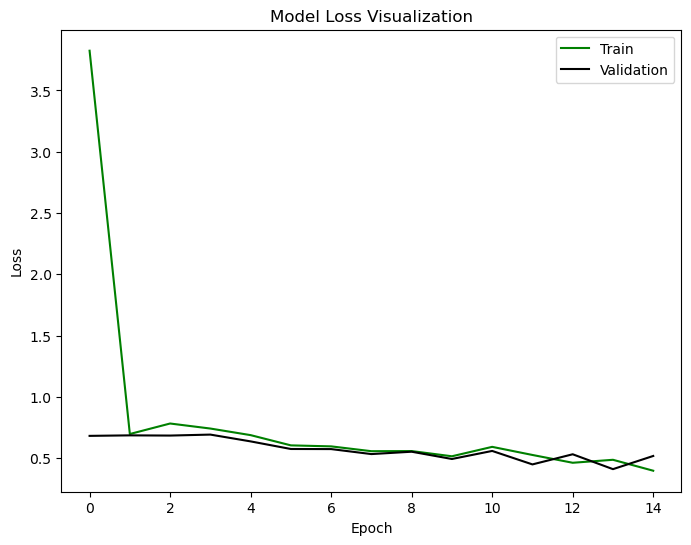

In [59]:
## Loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

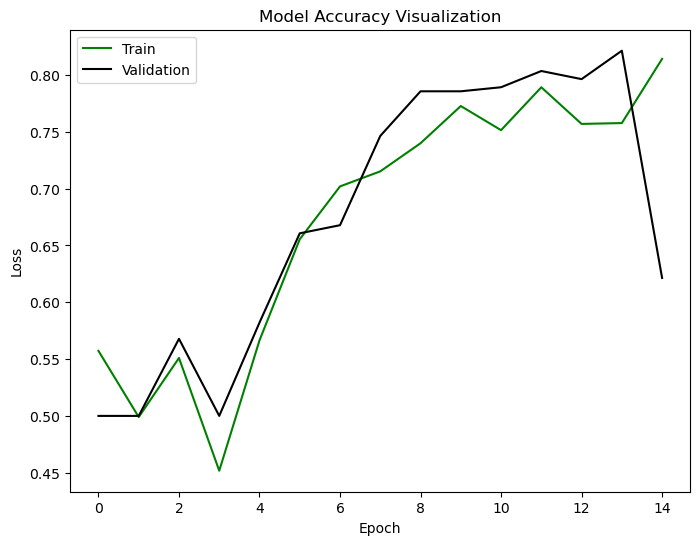

In [60]:
## Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [61]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

12/12 [==============================] - 9s 725ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       140
           1       1.00      0.24      0.39       140

    accuracy                           0.62       280
   macro avg       0.78      0.62      0.56       280
weighted avg       0.78      0.62      0.56       280



In [62]:
## Model on Testing Data.

testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 20 images belonging to 2 classes.
1/1 [==============================] - 1s 667ms/step
Classification report :

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       1.00      0.10      0.18        10

    accuracy                           0.55        20
   macro avg       0.76      0.55      0.44        20
weighted avg       0.76      0.55      0.44        20



## Transfer Learning With Inception V3

In [66]:
## Create model's layers.

pre_trained_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (250,250,3))
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
layer_ = tf.keras.layers.Flatten()(last_output)
layer_ = tf.keras.layers.Dense(512, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dense(256, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dropout(0.5)(layer_)
layer_ = tf.keras.layers.Dense(1, activation = 'sigmoid')(layer_)

model_4 = tf.keras.Model(pre_trained_model.input, layer_)


In [67]:
## Compile and print the summary of the model.

model_4.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', 
                metrics = 'accuracy')
print(model_4.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 124, 124, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_100 (Batch  (None, 124, 124, 32  96         ['conv2d_115[0][0]']             
 Normalization)                 )                                                           

 conv2d_126 (Conv2D)            (None, 28, 28, 32)   6144        ['average_pooling2d_15[0][0]']   
                                                                                                  
 batch_normalization_105 (Batch  (None, 28, 28, 64)  192         ['conv2d_120[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_107 (Batch  (None, 28, 28, 64)  192         ['conv2d_122[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_110 (Batch  (None, 28, 28, 96)  288         ['conv2d_125[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_137 (Conv2D)            (None, 28, 28, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_122 (Batch  (None, 28, 28, 64)  192         ['conv2d_137[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 28, 28, 64)   0           ['batch_normalization_122[0][0]']
                                                                                                  
 conv2d_135 (Conv2D)            (None, 28, 28, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_13

                                                                                                  
 activation_123 (Activation)    (None, 13, 13, 96)   0           ['batch_normalization_129[0][0]']
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 13, 13, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 13, 13, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_15[0][0]']       
                                                                                                  
 conv2d_14

 mixed4 (Concatenate)           (None, 13, 13, 768)  0           ['activation_124[0][0]',         
                                                                  'activation_127[0][0]',         
                                                                  'activation_132[0][0]',         
                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 13, 13, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 13, 13, 160)  480        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_169 (Conv2D)            (None, 13, 13, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_154 (Batch  (None, 13, 13, 160)  480        ['conv2d_169[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 13, 13, 160)  0           ['batch_normalization_154[0][0]']
                                                                                                  
 conv2d_170 (Conv2D)            (None, 13, 13, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 13, 13, 160)  480        ['conv2d_170[0][0]']             
 Normaliza

 activation_158 (Activation)    (None, 13, 13, 192)  0           ['batch_normalization_164[0][0]']
                                                                                                  
 conv2d_180 (Conv2D)            (None, 13, 13, 192)  258048      ['activation_158[0][0]']         
                                                                                                  
 batch_normalization_165 (Batch  (None, 13, 13, 192)  576        ['conv2d_180[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 13, 13, 192)  0           ['batch_normalization_165[0][0]']
                                                                                                  
 conv2d_176 (Conv2D)            (None, 13, 13, 192)  147456      ['mixed6[0][0]']                 
          

Total params: 75,560,865
Trainable params: 66,585,601
Non-trainable params: 8,975,264
__________________________________________________________________________________________________
None


In [68]:
## Model fitting.

history = model_4.fit(x = training_img, validation_data = validation_img, epochs = epoch, callbacks = [callbacks])

Epoch 1/15
80/80 [==============================] - 71s 872ms/step - loss: 5.9028 - accuracy: 0.8555 - val_loss: 0.0100 - val_accuracy: 0.9964
Epoch 2/15
80/80 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9955
Reached 98.0 % accuracy so cancelling training!
80/80 [==============================] - 75s 930ms/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.0057 - val_accuracy: 1.0000


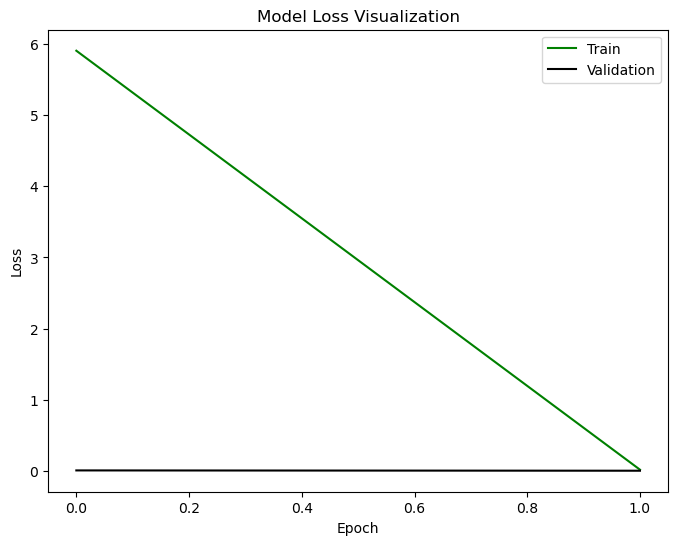

In [69]:
# Loss Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

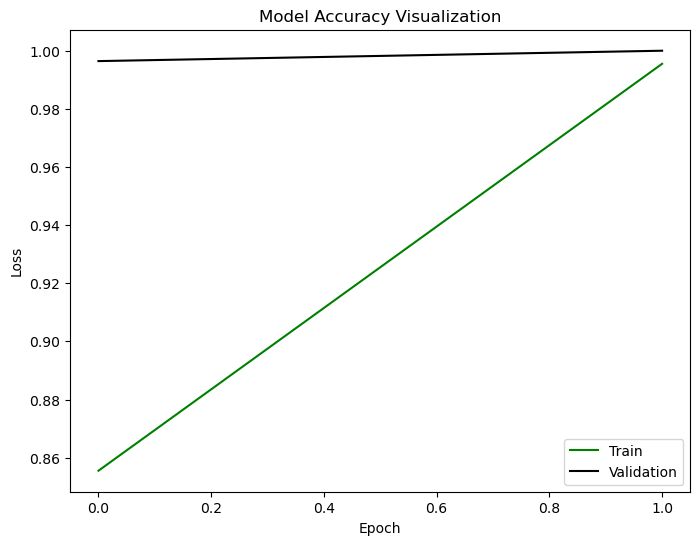

In [70]:
# Accuracy Visualization.

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [71]:
## Classfication Report.

val_pred = np.round(history.model.predict(validation_img)).reshape(-1,).astype('int32')
val_labels = validation_img.labels
report_val = classification_report(val_labels, val_pred)
print(report_val)

12/12 [==============================] - 4s 329ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       140

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [76]:
## Model on Testing Data.


testing_gen = ImageDataGenerator(rescale = 1./255)
testing_img = testing_gen.flow_from_directory(directory  = testing_dir, target_size = (250,250),
                                              class_mode = 'binary', shuffle = False)

test_pred = np.round(history.model.predict(testing_img)).reshape(-1,).astype('int32')
test_labels = testing_img.labels
report_test = classification_report(test_labels,test_pred)

print("Classification report :\n")
print(report_test)

Found 30 images belonging to 2 classes.
1/1 [==============================] - 0s 480ms/step
Classification report :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



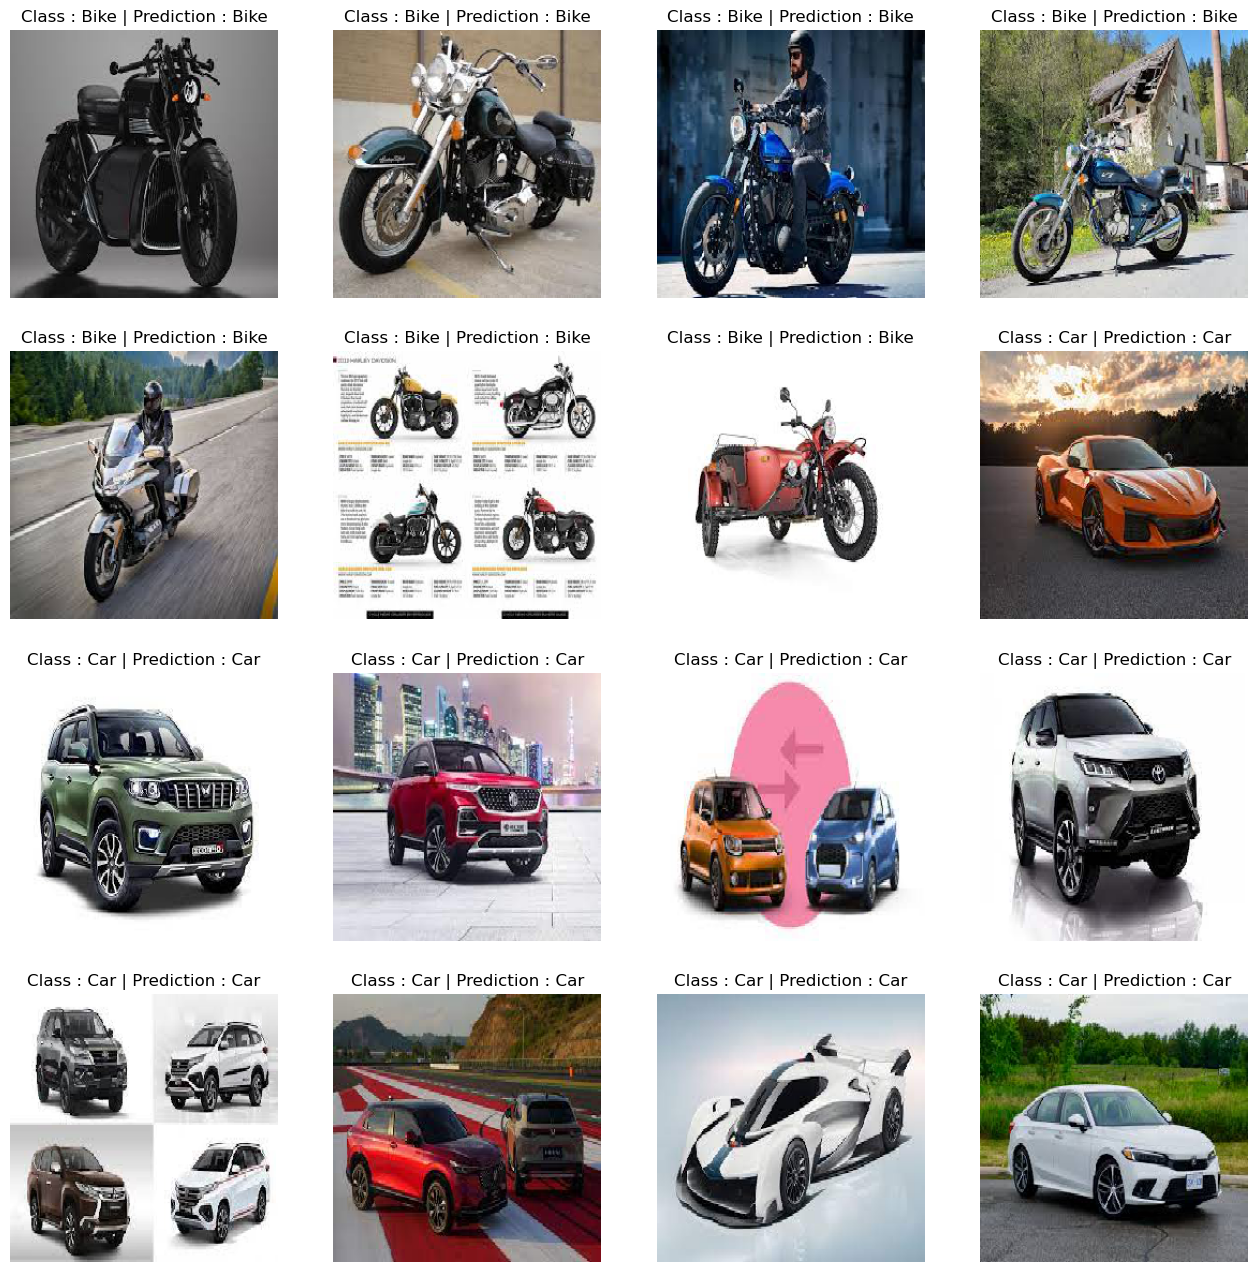

In [82]:
categories = ["Bike","Car"]

images, labels = testing_img.next()

n_rows = 4
n_cols = 4

fig = plt.gcf()
fig.set_size_inches(n_cols*4, n_rows*4)

for i, img in enumerate(images[8:24]):
    
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off') 
    plt.title(f"Class : {categories[labels[i+8].astype('uint8')]} | Prediction : {categories[test_pred[i+8].astype('uint8')]}")
    plt.imshow(img)


## Transfer learning with VGG 19

In [73]:
pre_trained_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (250,250,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

print(pre_trained_model.summary())

80134624/80134624 [==============================] - 16s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                             

## Hyperparameter Tuning

In [ ]:
## Resnet 50